In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int, Smooth
from spec_extract import Scale_spectra
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')
lzDB = galDB.query('z_grism < 1.5')
mzDB = galDB.query('1.5 < z_grism < 1.8')
hzDB = galDB.query('1.8 < z_grism < 2.1')
uhzDB = galDB.query('2.1 < z_grism')

lwa = np.load('../data/light_weight_scaling_3.npy')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
BFs = pd.read_pickle('../dataframes/BF_fit_all.pkl')

In [4]:
bfZ, bfd, bft, bftau, bfz, gids = [[],[],[],[],[],[]]

for i in BFs.index:
    bfZ.append(BFs.bfZ[i])
    bft.append(BFs.bft[i])
    bftau.append(BFs.bftau[i])
    bfz.append(np.round(BFs.bfz[i],3))
    bfd.append(np.round(BFs.bfd[i],1))
    gids.append(int(BFs.gids[i]))
    
bfZ = np.array(bfZ)
bft = np.array(bft)
bftau = np.array(bftau)
bfz = np.array(bfz)
bfd = np.array(bfd)
gids = np.array(gids)

In [5]:
def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)

def SN(w, f, e, wmin, wmax):
    
    IDx = [U for U in range(len(w)) if wmin < w[U] < wmax]
    
    return np.trapz(f[IDx])/ Sig_int(e[IDx])

def SN_full(Bw, Bf, Be, Rw, Rf, Re, Bmin, Bmax, Rmin, Rmax):
    
    IDb = [U for U in range(len(Bw)) if Bmin < Bw[U] < Bmax]
    IDr = [U for U in range(len(Rw)) if Rmin < Rw[U] < Rmax]
    
    return np.trapz(np.append(Bf[IDb],Rf[IDr]))/ Sig_int(np.append(Be[IDb],Re[IDr]))

In [6]:
Bwv = [] ; Bres = [] ; Bnerr = []
Rwv = [] ; Rres = [] ; Rnerr = []
Pwv = [] ; Pres = [] ; Pnerr = []

for i in galDB.index:
#     print(bfZ[gids == galDB.ids[i]][0], bft[gids == galDB.ids[i]][0],bftau[gids == galDB.ids[i]][0],
#                         bfz[gids == galDB.ids[i]][0], bfd[gids == galDB.ids[i]][0])
    sp = Gen_spec(galDB.field[i], galDB.ids[i], galDB.z_grism[i], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[i]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[i]))[0])   
    
    print(SN_full(sp.Bwv, sp.Bflx, sp.Berr,sp.Rwv, sp.Rflx, sp.Rerr, 8500, max(sp.Bwv),min(sp.Rwv), max(sp.Rwv)))
    if SN_full(sp.Bwv, sp.Bflx, sp.Berr,sp.Rwv, sp.Rflx, sp.Rerr, 8500, max(sp.Bwv),min(sp.Rwv), max(sp.Rwv)) > 5:
        
        
        if bftau[gids == galDB.ids[i]][0] == 0:
            BFTAU  = int(0)
        else:
            BFTAU = bftau[gids == galDB.ids[i]][0]

        sp.Sim_all(bfZ[gids == galDB.ids[i]][0], bft[gids == galDB.ids[i]][0],BFTAU,
                            bfz[gids == galDB.ids[i]][0], bfd[gids == galDB.ids[i]][0])
        Bwv.extend(sp.Bwv_rf)
        Bres.extend((sp.Bflx - sp.Bmfl) / sp.Bflx)
        Bnerr.extend(sp.Berr / sp.Bflx)    

        Rwv.extend(sp.Rwv_rf)
        Rres.extend((sp.Rflx - sp.Rmfl) / sp.Rflx)
        Rnerr.extend(sp.Rerr / sp.Rflx)    

        Pwv.extend(sp.Pwv_rf)
        Pres.extend((sp.Pflx - sp.Pmfl) / sp.Pflx)
        Pnerr.extend(sp.Perr / sp.Pflx)    

1.6664360656599477


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


5.292124110500191
1.0909221729665293
5.443644656302359


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


3.0517610559084423
3.4396083576864025
7.1341704744612695


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


8.18892867638491


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


6.104488050168485


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


1.4148732025613941
2.285132905648138
4.453948849782077


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


1.7432054511708976


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


2.4769414234227787
8.487485479395168


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


4.35349736379159
5.6646203129957025


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


18.921497357278028


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


3.67002900320996


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


8.039847938814042


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


8.822878011017993


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


11.62056221626822


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


3.4702795676343325
5.74151224257938


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


14.121303238045176


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5.561734210418371


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


3.298734143999774


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


2.957416846072334
14.075882727371532


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


12.878510542143541


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


1.2033338820288424
5.419304863557329


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


1.3257005075978865
3.4497546421112615


In [7]:
IDBW =np.array(Bwv).argsort()

B_wave = np.array(Bwv)[IDBW]
B_tmp_err = np.sqrt(np.array(Bres)**2 - np.array(Bnerr)**2)[IDBW]

B_wave_filt = B_wave[B_tmp_err**2 > 0]
B_tmp_err = B_tmp_err[B_tmp_err**2 > 0]

B_wave_filt = B_wave_filt[B_tmp_err < 100]
B_tmp_err = B_tmp_err[B_tmp_err < 100]

IDRW =np.array(Rwv).argsort()

R_wave = np.array(Rwv)[IDRW]
R_tmp_err = np.sqrt(np.array(Rres)**2 - np.array(Rnerr)**2)[IDRW]

R_wave_filt = R_wave[R_tmp_err**2 > 0]
R_tmp_err = R_tmp_err[R_tmp_err**2 > 0]

R_wave_filt = R_wave_filt[R_tmp_err < 100]
R_tmp_err = R_tmp_err[R_tmp_err < 100]

IDPW =np.array(Pwv).argsort()

P_wave = np.array(Pwv)[IDPW]
P_tmp_err = np.sqrt(np.array(Pres)**2 - np.array(Pnerr)**2)[IDPW]

P_wave_filt = P_wave[P_tmp_err**2 > 0]
P_tmp_err = P_tmp_err[P_tmp_err**2 > 0]

P_wave_filt = P_wave_filt[P_tmp_err < 100]
P_tmp_err = P_tmp_err[P_tmp_err < 100]

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Users/Vince

In [8]:
def Smooth(f,x,bw):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    
    if bw == 'none':
        bw = H
    
    fx = ksmooth.locpoly(x,f,bandwidth = bw)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [9]:
rzoo = importr('zoo')

In [14]:
def Run_stat(W,TMP,regionsize):
    df = pd.DataFrame({'wv':W, 'template_error':TMP})
    waves = df['wv']
    errf = df['template_error']

    eerr = rzoo.zoo(df.template_error[df.template_error > 0],waves[df.template_error > 0])

    emeanl = rzoo.rollapply(eerr,regionsize,'median', fill = 'NA', align ='left')
    emeanr = rzoo.rollapply(eerr,regionsize,'median', fill = 'NA', align ='right')

    newerrf = np.zeros(len(emeanl))
    for i in range(len(emeanl)):
        if np.abs(emeanl[i]) > 0:
            newerrf[i]=emeanl[i]
        else:
            newerrf[i]=emeanr[i]
            
#     return emeanl 
    return newerrf

(0, 2)

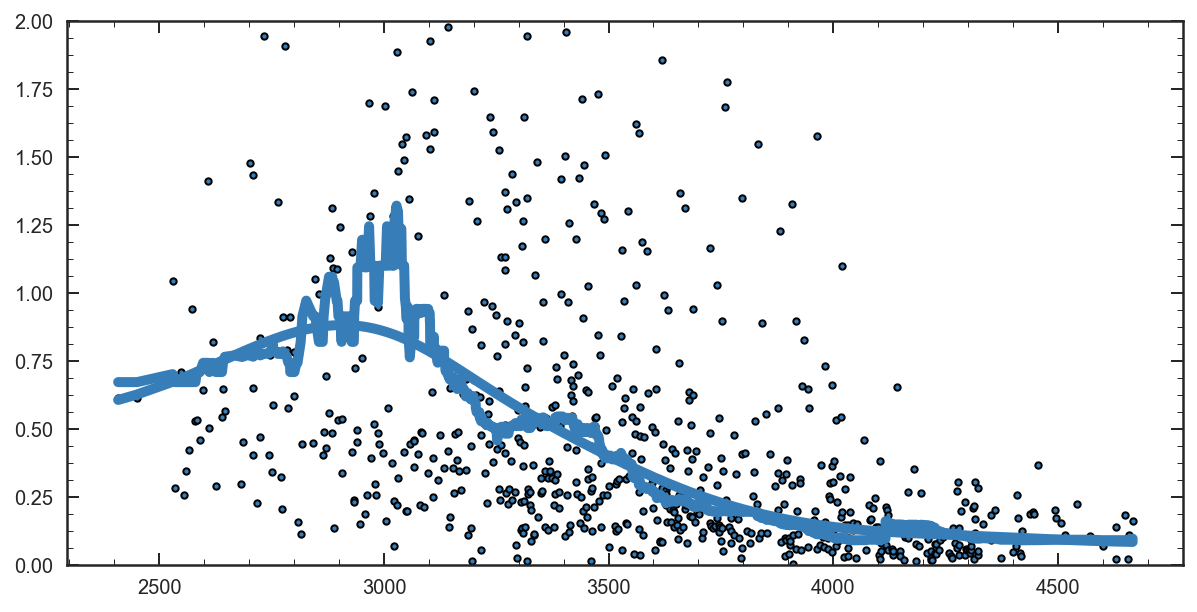

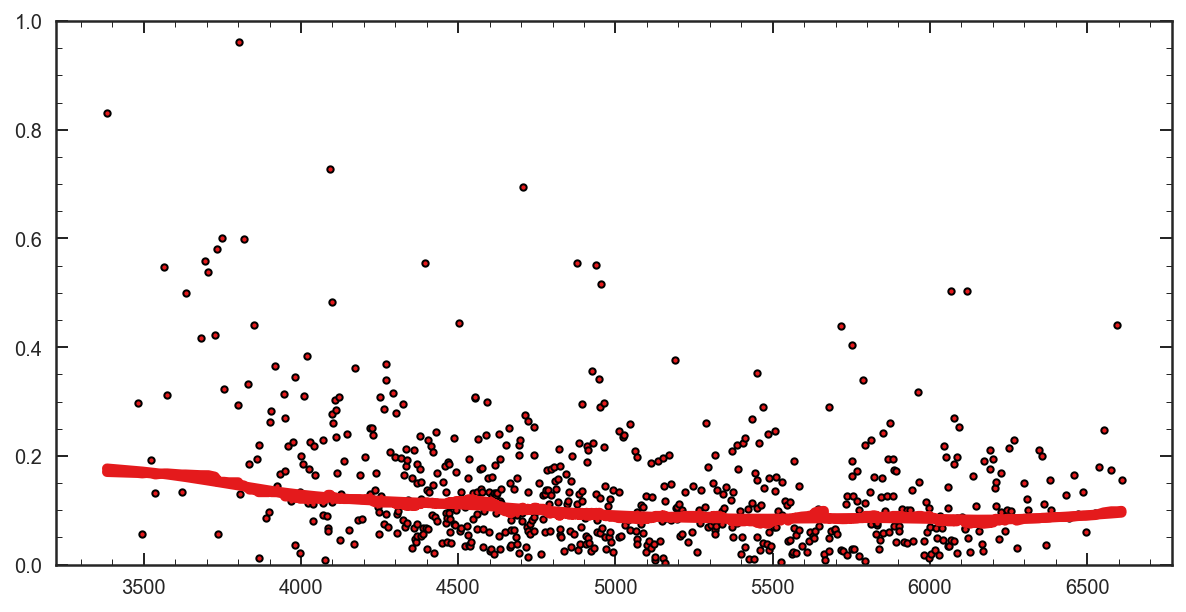

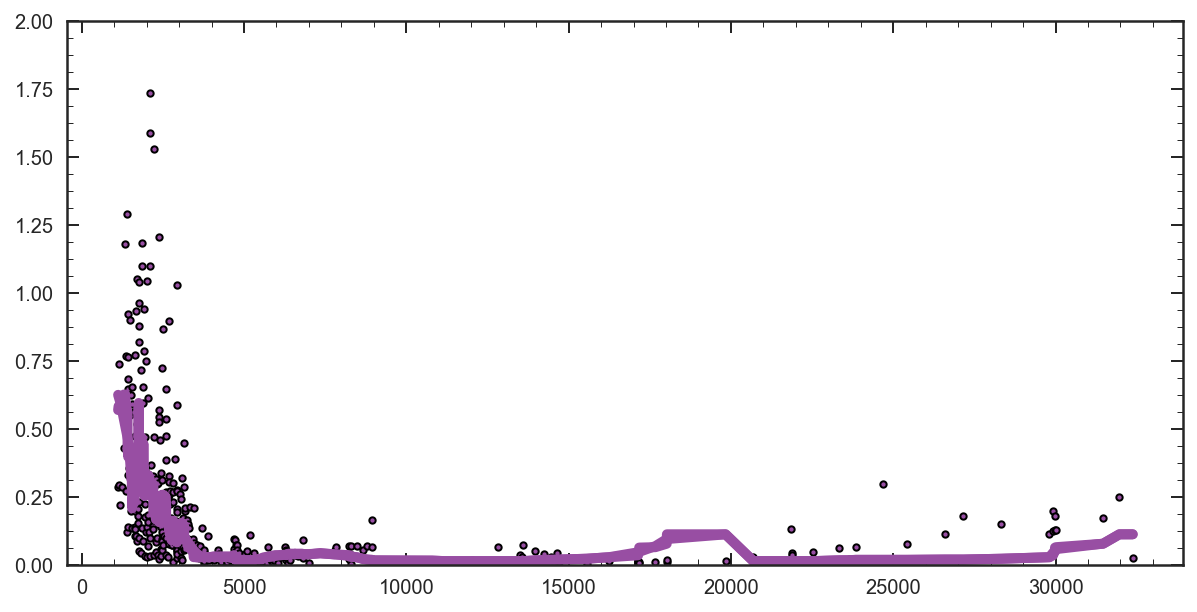

In [26]:
plt.figure(figsize=[10,5])
plt.scatter(B_wave_filt, B_tmp_err,facecolor = '#377eb8',edgecolors='k',linewidth=1,s=10)
# plt.plot(B_wave_filt,Smooth(B_tmp_err,B_wave_filt,500),'#377eb8',linewidth = 5)
plt.plot(B_wave_filt,Run_stat(B_wave_filt,B_tmp_err,100),'#377eb8',linewidth = 5)
plt.plot(B_wave_filt,Smooth(Run_stat(B_wave_filt,B_tmp_err,100),B_wave_filt,200),'#377eb8',linewidth = 5)

plt.ylim(0,2)

plt.figure(figsize=[10,5])
plt.scatter(R_wave_filt, R_tmp_err,facecolor = '#e41a1c',edgecolors='k',linewidth=1,s=10)
# plt.plot(R_wave_filt,Smooth(R_tmp_err,R_wave_filt,500),'#e41a1c',linewidth = 5)
plt.plot(R_wave_filt,Run_stat(R_wave_filt,R_tmp_err,150),'#e41a1c',linewidth = 5)
plt.plot(R_wave_filt,Smooth(Run_stat(R_wave_filt,R_tmp_err,150),R_wave_filt,200),'#e41a1c',linewidth = 5)

plt.ylim(0,1)

plt.figure(figsize=[10,5])
plt.scatter(P_wave_filt, P_tmp_err,facecolor = '#984ea3',edgecolors='k',linewidth=1,s=10)
# plt.plot(P_wave_filt,Smooth(P_tmp_err,P_wave_filt,500),'#984ea3',linewidth = 5)
plt.plot(P_wave_filt,Run_stat(P_wave_filt,P_tmp_err,25),'#984ea3',linewidth = 5)
plt.plot(P_wave_filt,Smooth(Run_stat(P_wave_filt,P_tmp_err,25),P_wave_filt,200),'#984ea3',linewidth = 5)

plt.ylim(0,2)
# plt.xlim(1000,5000)

In [65]:
galDB

0.4845342705957904

In [78]:
galDB.SNR

AttributeError: 'DataFrame' object has no attribute 'SNR'

In [76]:
x.split('_')[4]

'41250'